In [62]:
import numpy as np
import matplotlib.pyplot as plt

class Signal():
    """
    Complex envelope signal. 
    """
    def __init__(self, s_var, thetas, N, c=3e8, f0=2.4e9):
        """
        Initializes the signal model 
        params:
            power (float) : power of the signal
            thetas (list[float]) : list of azimut angles 
            N (int) : number of observations
            c (float) : velocity of propagation
            f0 : carrier frequency
        """
        self.c = c
        self.f0 = f0
        self.wavelength = c / f0
        self.N = N
        self.thetas = thetas
        self.var = s_var
        self.M = len(self.thetas)
        self.fi = np.random.uniform(0, np.pi * 2, (self.M, N))
        self.s = np.sqrt(s_var) * np.exp(1j * self.fi)
        self.s[0, :250] = 0
        plt.plot(self.s[0, :])
        plt.show()
    
    def log(self):
        print("Generated signal:")
        print(f"\tshape: {self.s.shape}")
        print(f"\tsamples: {self.N}")
        print(f"\tazimut angles: {self.thetas}")



class ULA():
    """
    Universal Linear Array
    """

    def __init__(self, d, L, snr, signal : Signal):
        """
        Initializes the Universal Linear Array
        params:
            d (float): distance between the sensors
            L (int): dimension of the array (number of sensors)
            s (Signal): signal
        """
        self.d = d
        self.L = L
        self.A = None
        self.signal = signal
        self.s = signal.s
        self.snr = snr
        self.get_steering(self.signal)

    def log(self):
        print("Generated ULA:")
        print(f"\tsignal shape: {self.s.shape}")
        print(f"\tarray dimension: {self.L}")
        print(f"\tdistance between sensors: {self.d}")
        print(f"\tsteering matrix shape: {self.A.shape}")

    
    def get_steering(self, s : Signal):
        self.A = np.array([[np.exp(1j * 2 * np.pi * self.d / s.wavelength * l * np.cos(theta)) for l in range(self.L)] for theta in s.thetas]).T
        print(f'A.dtype = {self.A.dtype}')

    def clean_response(self):
        """
        Returns a non-noisy response of the array for a signal s. 
        x = A @ s, where A is the response matrix, and s is the signal 
        params: 
        returns:
            x : dim(L,1)
        """

        self.x = self.A @ self.s
        return self.x

    def noisy_response(self):
        """
        Returns a nosiy response of the array for a signal s. The noise is a Gaussian white noise. 
        params: 
            snr : Signal-to-noise-ratio in dB
        """
        self.get_steering(self.signal)
        snr_lin = 10.0 ** (self.snr / 10.0)
        print(f's shape: {self.s.shape}')
        #for i in range(299):
        #    self.s[:,i] = 0 
        self.x = self.A @ self.s
        x_var = self.x.var()
        n_var = x_var / snr_lin
        n = np.random.normal(0, np.sqrt(n_var*2.0)/2.0, size=(self.L, 2*self.signal.N)).view(complex)
        return self.x + n


class BarlettBeamformer():
    """
    Barlett beamformer. 
    """
    def __init__(self, M, resolution, ula: ULA ):
        """
        Initializes the BarlettBeamformer.
        params:
            M: number of inpinging waves
            resolution: resolution of the beamforming
            ula: the ULA we want to use the Barlett beamformer with
            
        """
        self.M = M
        self.ula = ula
        self.P = np.zeros(resolution, dtype=np.complex128)
        self.thetas = np.linspace(-np.pi, np.pi, resolution, endpoint=True)
        self.x = ula.noisy_response()
        print(f'x shape: {self.x.shape}')
        R = self.x @ self.x.conj().T 
        a = np.zeros((ula.L, 1), dtype=np.complex128)
        for i, theta in enumerate(self.thetas):
            a[:,0] = np.array([np.exp(1j * 2 * np.pi * l * (ula.d / ula.signal.wavelength * np.cos(theta))) for l in range(ula.L)])
            self.P[i] = (a.conjugate().T @ R @ a) / np.linalg.norm(a) ** 4
        print(R.shape)
        print(a.shape)
        print(a.dtype)
        self.P /= self.P.max()


class CaponBeamformer():
    """
    Capon beamformer
    """
    def __init__(self, M, resolution, ula: ULA):
        """
        Initializes the Capon beamformer
        params: 
            M: number of impinging waves
            resolution: resolution of the beamforming
            ula: ULA
        """
        self.M = M
        self.ula = ula
        self.P = np.zeros(resolution, dtype=np.complex128)
        self.thetas = np.linspace(-np.pi, np.pi, resolution, endpoint=True)
        self.x = ula.noisy_response()
        R = self.x @ self.x.conj().T
        a = np.zeros((ula.L, 1), dtype=np.complex128)
        for i, theta in enumerate(self.thetas):
            a[:,0] = np.array([np.exp(1j * 2 * np.pi * l * (ula.d / ula.signal.wavelength * np.cos(theta))) for l in range(ula.L)])
            self.P[i] = 1 / (a.conjugate().T @ np.linalg.pinv(R) @ a)
        self.P /= self.P.max()

class SpectralMUSIC_1D():
    """
    1D Spectral MUSIC algorithm
    """
    def __init__(self, M, resolution, ula: ULA):
        """
        Initializes the MUSIC algorithm
        """
        self.M = M
        self.ula = ula
        self.P = np.zeros(resolution, dtype=np.complex128)
        self.thetas = np.linspace(-np.pi, np.pi, resolution, endpoint=True)
        self.x = ula.noisy_response()
        print(f'x shape {self.x.shape}')
        R = self.x @ self.x.conj().T / ula.signal.N
        a = np.zeros((ula.L, 1), dtype=np.complex128)
        w, v = np.linalg.eig(R)
        i = np.argsort(w)
        print(i[0:2])
        v = v[:, i]
        U = v[:, 0:(ula.L - self.M)]
        print(f'U shape = {U.shape}')
        for i, theta in enumerate(self.thetas):
            a[:,0] = np.array([np.exp(1j * 2 * np.pi * l * (ula.d / ula.signal.wavelength * np.cos(theta))) for l in range(ula.L)])
            self.P[i] = 1 / (a.conjugate().T @ U @ U.conjugate().T @ a)
        self.P /= self.P.max()

In [2]:
class Signal2D():
    """
    2D Signal model
    """
    def __init__(self, s_var:float, thetas:list[float], fis:list[float], N:int, c=3e8, f0=2.4e9):
        """
        2D Signal model
        params:
            s_var (float) : variance fothe signal
            thetas (list[float]) : list of azimut angles
            fis (list[float]) : list of elevation angles
            N (int) : number of observations
            c (float) : velocty of propagation
            f0 : carrier frequency
        """
        self.c = c
        self.f0 = f0
        self.wavelength = c / f0
        self.N = N
        self.thetas = thetas
        self.fis = fis
        self.var = s_var
        self.M = min(len(self.thetas), len(self.fis))
        self.phi_rand = np.random.uniform(0, np.pi * 2, (self.M, N))
        self.s = np.sqrt(s_var) * np.exp(1j * self.phi_rand)

class UPA():
    """
    Universal Planar Array
    """
    def __init__(self, dx, dy, Lx, Ly, snr, signal:Signal2D):
        """
        Universal Planar array
        params:
            dx (float) : distance between the sensors along x-axis (hint: wavelength / 2) 
            dy (float) : distnace between the sensors along y-axis (hint: wavelength / 2)
            Lx (int) : number of sensors (dimension) along x-axis
            Ly (int) : number of sensors (dimension) along y-axis
            snr (float) : signal to noise ratio
            signal (Signal) : impinging signal
        """
        self.dx = dx
        self.dy = dy
        self.Lx = Lx
        self.Ly = Ly
        self.L = self.Lx * self.Ly
        self.snr = snr
        self.signal = signal
        self.s = signal.s
        self.rs = np.zeros((3, self.Lx, self.Ly))
        self.get_steering()

    def get_steering(self):
        """
        Returns the steering matrix for 2D case
        """
        self.es = np.array([np.array([np.sin(theta) * np.cos(fi), np.sin(theta) * np.sin(fi), np.cos(theta)]) for theta, fi in zip(self.signal.thetas, self.signal.fis)])
        self.rs = self.get_sensor_positions().T
        print(f'r shape: {self.rs.shape}')
        print(f'e shape: {self.es.shape}')
        self.A = np.array([[np.exp(1j * 2 * np.pi / self.signal.wavelength * e.T @ r) for r in self.rs] for e in self.es]).T
        print(f'A shape: {self.A.shape}')

    def get_sensor_positions(self):
        for lx in range(self.Lx):
            for ly in range(self.Ly):
                self.rs[0, lx, ly] = self.dx * lx # x dimension of r_xy
                self.rs[1, lx, ly] = self.dy * ly # y dimension of r_xy
        self.rs = self.rs.reshape(3, self.Lx * self.Ly)
        return self.rs


    def get_noisy_response(self):
        self.x = self.A @ self.s
        self.x = self.x.reshape(self.L, self.signal.N)
        snr_lin = 10.0 ** (self.snr / 10.0)
        x_var = self.x.var()
        n_var = x_var / snr_lin
        n = np.random.normal(0, np.sqrt(n_var*2.0)/2.0, size=(self.Lx * self.Ly, 2*self.signal.N)).view(complex)
        n = n.reshape(100, self.signal.N)
        print(f'x shape:{self.x.shape}')
        self.x = self.x + n
        return self.x


class MUSIC_2D():
    """
    2D Spectral MUSIC algorithm
    """
    def __init__(self, M, resolution, upa : UPA):
        """
        2D Spectral MUSIC algorithm
        """
        self.M = M
        self.upa = upa
        self.resolution = resolution
        self.thetas = np.linspace(0, np.pi/2, resolution, endpoint=True)
        self.fis = np.linspace(0, np.pi/2, resolution, endpoint=True)
        self.x = upa.get_noisy_response()
        R = self.x @ self.x.conj().T / upa.signal.N
        print(f'N = {upa.signal.N}')
        w, v = np.linalg.eig(R)
        i = np.argsort(w)
        v = v[:, i]
        U = v[:, 0:(upa.L - self.M)]
        print(f'U shape: {U.shape}')
        rs = upa.rs
        self.P = np.zeros((self.thetas.shape[0], self.fis.shape[0]), dtype=np.complex128)
        self.rs = upa.rs.T
        print(f'r shape: {self.rs.shape}')
        lambd = upa.signal.wavelength
        print(f'lambda = {lambd}')
        for i, theta in enumerate(self.thetas):
            for j, fi in enumerate(self.fis):
                e = np.array([np.sin(theta) * np.cos(fi), np.sin(theta) * np.sin(fi), np.cos(theta)])
                #rint(e.shape)
                #rint(rs.shape)
                a = np.exp(2j * np.pi / lambd * e @ self.rs)
                self.P[i, j] = 1 / (a.conj().T @ U @ U.conj().T @ a)




In [ ]:
thetas = np.deg2rad([0, 45, 70])
fis = np.deg2rad([0, 45, 70])

signal = Signal2D(10, thetas , fis, 100)
upa = UPA(signal.wavelength/2, signal.wavelength/2, 10, 10, 5, signal)
print(upa.s.shape)
print(upa.A.shape)



In [ ]:
music_2d = MUSIC_2D(3, 200, upa)
thetas_out = np.rad2deg(music_2d.thetas)
fis_out = np.rad2deg(music_2d.fis)

In [5]:
def MUSIC_2(x, r, M, resolution=None, f0=2.4e9):
    L, N = x.shape
    if resolution is None:
        resolution = 2 * N
    el_search = np.linspace(start=0, stop=np.pi/2, num=resolution, endpoint=True)
    az_search = np.linspace(start=0, stop=np.pi/2, num=resolution, endpoint=True)
    lambd = 300e6 / f0
    print(f'lambda = {lambd}')
    # Compute covariance matrix from observations
    Rxx = x @ x.conj().T / N

    # Form Un from the L-M eigenvectors associated with the L-M leasts eigenvalues of Rxx
    eig_vals, eig_vecs = np.linalg.eig(Rxx)
    idx = np.argsort(eig_vals)
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:, idx]
    Un = eig_vecs[:, 0:(L-M)]
    print(f'Un shape: {Un.shape}')

    # Determine the frequency estimates as the M directions corresponding to the M highest maxima
    Pm = np.zeros((resolution, resolution), dtype=complex)
    for i in range(resolution):
        for j in range(resolution):

            e = np.array([np.sin(el_search[i]) * np.cos(az_search[j]), 
                      np.sin(el_search[i]) * np.sin(az_search[j]), 
                      np.cos(el_search[i])])

            
            a = np.exp(2j * np.pi / lambd * e @ r)



            
            Pm[i, j] = 1 / (a.conj().T @ Un @ Un.conj().T @ a)
    return Pm, np.rad2deg(el_search), np.rad2deg(az_search)

In [ ]:

print(upa.rs.shape)
print(upa.x.shape)
Pm, el_search, az_search = MUSIC_2(upa.get_noisy_response(), upa.rs.T, 3)

fig, ax = plt.subplots()
ax.pcolormesh(el_search, az_search, np.abs(Pm))
print(Pm.shape)

In [ ]:
print(music_2d.P.shape)


fig, ax = plt.subplots()
ax.pcolormesh(thetas_out, fis_out, np.abs(music_2d.P))

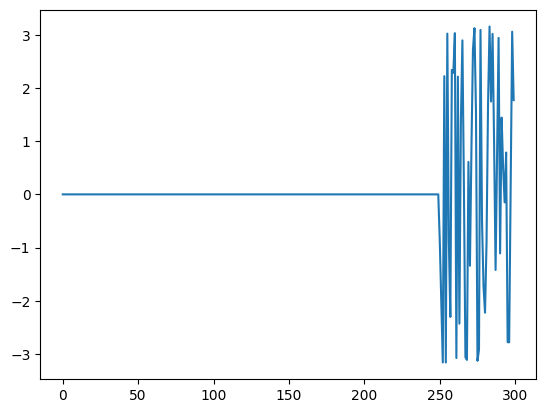

A.dtype = complex128
A.dtype = complex128
s shape: (2, 300)
x shape: (5, 300)
(5, 5)
(5, 1)
complex128


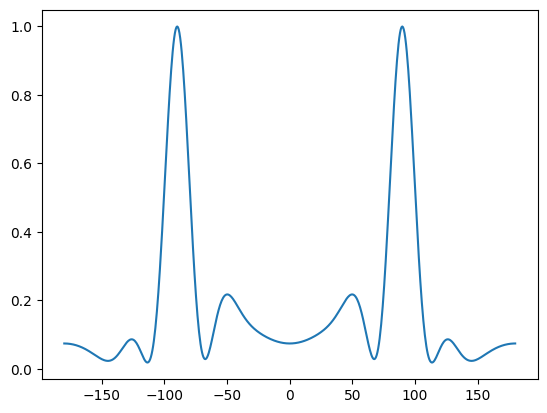

In [63]:
s= Signal(10, [np.deg2rad(45), np.deg2rad(90)], 300)
ula = ULA(s.wavelength/2, 5, 11, s)
barlett = BarlettBeamformer(2, 600, ula)
#capon = CaponBeamformer(2, 2000, ula)
#music_1d = SpectralMUSIC_1D(2, 2000, ula)
plt.plot(np.rad2deg(barlett.thetas), barlett.P)
#plt.plot(np.rad2deg(capon.thetas), capon.P)
#plt.plot(np.rad2deg(music_1d.thetas), music_1d.P)
plt.show()
